In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import sklearn
import pickle
from sklearn.decomposition import PCA

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
class Inputs():
    def __init__(self, deltaP, maxSamples, empirical=None, seed=0):
        self.deltaP = deltaP
        self.maxSamples = maxSamples
        self.empirical = empirical
        self.winning = None
        self.pA = None
        self.pB = None
        self.dP_actual = None
        self.As = []
        self.Bs = []
        self.rng = np.random.RandomState(seed=seed)
    def set_AB(self):
        self.winning = "A" if self.rng.rand()<0.5 else "B"
        highs = np.arange(0.1+self.deltaP, 0.9, 0.1)
        high = highs[self.rng.randint(len(highs))]
        low = high - self.deltaP
        nUpWin = int(high*self.maxSamples)
        nUpLose = int(low*self.maxSamples)
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if self.winning=="A":
            self.As[:nUpWin] = 1
            self.As[nUpWin:] = -1
            self.Bs[:nUpLose] = 1
            self.Bs[nUpLose:] = -1
            self.pA = nUpWin / self.maxSamples
            self.pB = nUpLose / self.maxSamples
        else:
            self.Bs[:nUpWin] = 1
            self.Bs[nUpWin:] = -1
            self.As[:nUpLose] = 1
            self.As[nUpLose:] = -1
            self.pB = nUpWin / self.maxSamples
            self.pA = nUpLose / self.maxSamples
        self.rng.shuffle(self.As)
        self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def set_AB_empirical(self, trial, initialize=True):
        self.pA = self.empirical['pA'].to_numpy()[trial]
        self.pB = self.empirical['pB'].to_numpy()[trial]
        self.winning = "A" if self.pA>self.pB else "B"
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if initialize:  # populate the A and B arrays with the samples actually drawn in the empirical trial
            empAs = list(str(self.empirical['A'].to_numpy()[trial]))
            empAs = np.array([2*int(x)-1 for x in empAs])
            empBs = list(str(self.empirical['B'].to_numpy()[trial]))
            empBs = np.array([2*int(x)-1 for x in empBs])
            self.As[:len(empAs)] = empAs
            self.Bs[:len(empBs)] = empBs
            self.As[len(empAs):] = 2*self.rng.randint(2, size=self.maxSamples-len(empAs))-1
            self.Bs[len(empBs):] = 2*self.rng.randint(2, size=self.maxSamples-len(empBs))-1
        else:
            if self.winning=="A":
                self.As[:nUpWin] = 1
                self.As[nUpWin:] = -1
                self.Bs[:nUpLose] = 1
                self.Bs[nUpLose:] = -1
            else:
                self.Bs[:nUpWin] = 1
                self.Bs[nUpWin:] = -1
                self.As[:nUpLose] = 1
                self.As[nUpLose:] = -1
            self.rng.shuffle(self.As)
            self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def get_AB(self, t):
        AB = [self.As[int(t)], self.Bs[int(t)]] if t<self.maxSamples else [0,0]
        AB = [AB[0], 0] if t%1.0<0.5 else [0, AB[1]]  # A presented for 500ms, then B presented for 500ms
        return AB

In [3]:
def build_network(inputs, nNeurons=1000, tau=0.1, seed=0, w_time=0, w_ramp=0.2, w_delta=0, T=0.3, S=[0,0]):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    
    func_evidence = lambda t: inputs.get_AB(t)
    func_thr = lambda t: T
    func_start = lambda t: S if t<1 else [0,0]
    func_urgency = lambda t: -w_time * t
    func_ramp = lambda x: tau * w_ramp * x
    func_uncertainty = lambda x: -w_delta * np.abs(x[0]-x[1])
    func_greater = lambda x: [x[0]-x[1], x[1]-x[0]] 
    
    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0.01, 1)
    dInh = -1e1*np.ones((2*nNeurons, 1))

    with net:
        # Inputs
        evidence = nengo.Node(func_evidence)
        time = nengo.Node(func_urgency)
        thr = nengo.Node(func_thr)
        start = nengo.Node(func_start)
        
        # Ensembles
        value = nengo.networks.EnsembleArray(nNeurons, 2)
        accumulate = nengo.networks.EnsembleArray(nNeurons, 2)
        combined = nengo.Ensemble(2*nNeurons, 2)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, 2, encoders=ePos, intercepts=iPos)
        
        # Connections
        nengo.Connection(evidence, value.input)
        nengo.Connection(start[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(start[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(accumulate.output, accumulate.input, synapse=tau)
        nengo.Connection(accumulate.output, combined)
        nengo.Connection(combined, gate, function=func_uncertainty)
        nengo.Connection(combined, action.input, function=func_greater)
        nengo.Connection(time, gate)
        nengo.Connection(thr, gate)
        nengo.Connection(gate, action.input, transform=[[-1], [-1]])

        # Probes
        net.pEvidence = nengo.Probe(evidence)
        net.pValue = nengo.Probe(value.output)
        net.pAccumulate = nengo.Probe(accumulate.output)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        
        # references
        net.w_ramp = w_ramp
        net.w_delta = w_delta
        
    return net

In [4]:
def is_correct(inputs, net, sim, dt=0.001, action_threshold=0.0):
    chooseA = np.argwhere(sim.data[net.pAction][:,0] > action_threshold)
    chooseB = np.argwhere(sim.data[net.pAction][:,1] > action_threshold)
    timeA = chooseA[0][0]*dt if len(chooseA)>0 else sim.trange()[-1]
    timeB = chooseB[0][0]*dt if len(chooseB)>0 else sim.trange()[-1]
    if inputs.winning=="A":
        if timeA == timeB:  # forced response
            correct = 1 if sim.data[net.pAccumulate][-1][0] > sim.data[net.pAccumulate][-1][1] else False
            time = timeA
        elif timeA < timeB:
            correct = 1
            time = timeA
        elif timeB < timeA:
            correct = 0
            time = timeB
    elif inputs.winning=="B":
        if timeB == timeA:  # forced response
            correct = 1 if sim.data[net.pAccumulate][-1][1] > sim.data[net.pAccumulate][-1][0] else False
            time = timeB
        elif timeB < timeA:
            correct = 1
            time = timeB
        elif timeA < timeB:
            correct = 0
            time = timeA
    return correct, int(np.ceil(2*time)), time

In [5]:
def run_trials(args, deltaPs=[0.4, 0.2, 0.1], load=False, progress_bar=True):
    participant_id = args['participant_id']
    if load:
        data = pd.read_pickle(f"data/{participant_id}.pkl")
    else:
        dfs = []
        columns = ('agent', 'dP', 'trial', 'cues', 'correct')
        for dP in deltaPs:
            empirical_data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12 & delta==@dP & participant_id==@participant_id")
            empirical_cues = empirical_data['cues'].to_numpy()
            empirical_accuracy = empirical_data['correct'].to_numpy()
            inputs = Inputs(deltaP=dP, maxSamples=12, seed=args['seed'], empirical=empirical_data)
            inputs.set_AB_empirical(0)
            net = build_network(inputs, T=args['T'], w_ramp=args['w_ramp'], w_time=args['w_time'], w_delta=args['w_delta'], seed=args['seed'])

            for trial in range(empirical_data.shape[0]):
                print(f"trial {trial}")
                inputs.set_AB_empirical(trial)
                sim = nengo.Simulator(net, progress_bar=False)
                with sim:
                    sim.run(12, progress_bar=progress_bar)
                correct, cue, time = is_correct(inputs, net, sim)
                dfs.append(pd.DataFrame([['model', dP, trial, cue, 1.0*correct,]], columns=columns))
                dfs.append(pd.DataFrame([['human', dP, trial, empirical_cues[trial], 1.0*empirical_accuracy[trial]]], columns=columns))

        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{participant_id}.pkl")
    return data

# Fast and Slow Individuals

In [6]:
args_fast = {
    'participant_id': '58c54d6d2775404a9c3a3cde65c32a71',
    'seed':74,
    'T':0.31,
    'w_ramp':0.1,
    'w_time':0.04,
    'w_delta':0.7,
}
args_slow = {
    'participant_id': 'ece1f226b161426aafd433aa0e933b5d',
    'seed':417,
    'T':0.21,
    'w_ramp':0.12,
    'w_time':0.0,
    'w_delta':0.0,
}
fast_data = run_trials(args=args_fast, load=True)
slow_data = run_trials(args=args_slow, load=True)

     agent   dP  trial  cues  correct
0    model  0.4      0     5      1.0
1    human  0.4      0     5      1.0
2    model  0.4      1     7      0.0
3    human  0.4      1     6      0.0
4    model  0.4      2     8      1.0
..     ...  ...    ...   ...      ...
283  human  0.1     45    13      0.0
284  model  0.1     46     8      1.0
285  human  0.1     46     5      1.0
286  model  0.1     47     7      0.0
287  human  0.1     47     6      0.0

[288 rows x 5 columns]


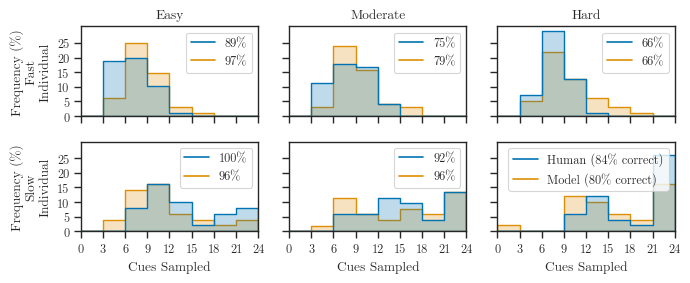

In [16]:
# fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=((6.28, 3)))
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=((7.07, 3)))
sns.histplot(data=fast_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0][0], stat='percent', multiple='layer', element='step', linewidth=1)
sns.histplot(data=fast_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0][1], stat='percent', multiple='layer', element='step', linewidth=1)
sns.histplot(data=fast_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0][2], stat='percent', multiple='layer', element='step', linewidth=1)
axes[0][0].get_legend().remove()
axes[0][1].get_legend().remove()
axes[0][2].get_legend().remove()
easy_human = int(100*fast_data.query("dP==0.4 & agent=='human'")['correct'].mean())
moderate_human = int(100*fast_data.query("dP==0.2 & agent=='human'")['correct'].mean())
hard_human = int(100*fast_data.query("dP==0.1 & agent=='human'")['correct'].mean())
easy_model = int(100*fast_data.query("dP==0.4 & agent=='model'")['correct'].mean())
moderate_model = int(100*fast_data.query("dP==0.2 & agent=='model'")['correct'].mean())
hard_model = int(100*fast_data.query("dP==0.1 & agent=='model'")['correct'].mean())
sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{easy_human}%", ax=axes[0][0])
sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{moderate_human}%", ax=axes[0][1])
sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{hard_human}%", ax=axes[0][2])
sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{easy_model}%", ax=axes[0][0])
sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{moderate_model}%", ax=axes[0][1])
sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{hard_model}%", ax=axes[0][2])
axes[0][0].set(xlabel=None, title="Easy", ylabel="Frequency (%)\nFast\nIndividual", yticks=((0, 5, 10, 15, 20, 25)))
axes[0][1].set(xlabel=None, title="Moderate")
axes[0][2].set(xlabel=None, title="Hard")

sns.histplot(data=slow_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1][0], stat='percent', multiple='layer', element='step', linewidth=1)
sns.histplot(data=slow_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1][1], stat='percent', multiple='layer', element='step', linewidth=1)
sns.histplot(data=slow_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1][2], stat='percent', multiple='layer', element='step', linewidth=1)
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
axes[1][2].get_legend().remove()
easy_human = int(100*slow_data.query("dP==0.4 & agent=='human'")['correct'].mean())
moderate_human = int(100*slow_data.query("dP==0.2 & agent=='human'")['correct'].mean())
hard_human = int(100*slow_data.query("dP==0.1 & agent=='human'")['correct'].mean())
easy_model = int(100*slow_data.query("dP==0.4 & agent=='model'")['correct'].mean())
moderate_model = int(100*slow_data.query("dP==0.2 & agent=='model'")['correct'].mean())
hard_model = int(100*slow_data.query("dP==0.1 & agent=='model'")['correct'].mean())
sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{easy_human}%", ax=axes[1][0])
sns.lineplot(x=[0],y=[0], color=palette[0], label=f"{moderate_human}%", ax=axes[1][1])
sns.lineplot(x=[0],y=[0], color=palette[0], label=f"Human ({hard_human}% correct)", ax=axes[1][2])
sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{easy_model}%", ax=axes[1][0])
sns.lineplot(x=[0],y=[0], color=palette[1], label=f"{moderate_model}%", ax=axes[1][1])
sns.lineplot(x=[0],y=[0], color=palette[1], label=f"Model ({hard_model}% correct)", ax=axes[1][2])
axes[1][0].set(xlabel='Cues Sampled', xticks=np.arange(0, 27, 3), xlim=((0, 24)), ylabel='Frequency (%)\nSlow\nIndividual')
axes[1][1].set(xlabel='Cues Sampled', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[1][2].set(xlabel='Cues Sampled', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/extremes.svg")
fig.savefig(f"plots/extremes.png", dpi=600)

# Speed Accuracy Tradeoff

In [18]:
f = open('optimized.json')
optimized = json.load(f)
dfs = []
for pid, args in optimized.items():
    try:
        dfs.append(pd.read_pickle(f"data/optimized/{pid}_collapsed.pkl"))
    except:
        print(f"no data for {pid}")
sat_data = pd.concat(dfs, ignore_index=True)
# print(sat_data.to_string())

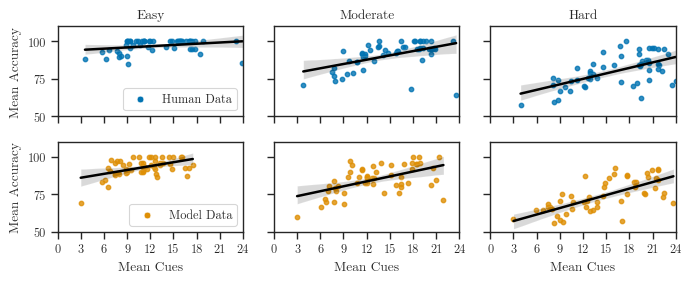

In [22]:
sat_data2 = sat_data
sat_data2['correct'] = 100*sat_data['mean correct']

# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((7.08, 3)), sharex=True, sharey=True)
sns.regplot(data=sat_data2.query("agent=='human' & dP==0.4"), x='mean cues', y='correct', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][0])
sns.regplot(data=sat_data2.query("agent=='human' & dP==0.2"), x='mean cues', y='correct', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][1])
sns.regplot(data=sat_data2.query("agent=='human' & dP==0.1"), x='mean cues', y='correct', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][2])
sns.regplot(data=sat_data2.query("agent=='model' & dP==0.4"), x='mean cues', y='correct', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][0])
sns.regplot(data=sat_data2.query("agent=='model' & dP==0.2"), x='mean cues', y='correct', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][1])
sns.regplot(data=sat_data2.query("agent=='model' & dP==0.1"), x='mean cues', y='correct', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][2])
# sns.regplot(data=sat_data.query("agent=='human' & dP==0.4"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[2], ax=axes[0])
# sns.regplot(data=sat_data.query("agent=='human' & dP==0.2"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[0], ax=axes[1])
# sns.regplot(data=sat_data.query("agent=='human' & dP==0.1"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[1], ax=axes[2])
sns.scatterplot(x=[0],y=[0], color=palette[0], label=f"Human Data", ax=axes[0][0])
sns.scatterplot(x=[0],y=[0], color=palette[1], label=f"Model Data", ax=axes[1][0])
axes[0][0].set(ylabel='Mean Accuracy', xlabel=None, title="Easy", ylim=((50, 110)), yticks=((50, 75, 100)))
axes[0][1].set(ylabel=None, xlabel=None, title="Moderate")
axes[0][2].set(ylabel=None, xlabel=None, title="Hard", xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[1][0].set(ylabel='Mean Accuracy', xlabel='Mean Cues', ylim=((50, 110)), yticks=((50, 75, 100)))
axes[1][1].set(ylabel=None, xlabel='Mean Cues')
axes[1][2].set(ylabel=None, xlabel='Mean Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[0][0].legend(loc='lower right')
axes[1][0].legend(loc='lower right')

plt.tight_layout()
fig.savefig(f"plots/trend.svg")
fig.savefig(f"plots/trend.png", dpi=600)

# Compare mechanisms

In [ ]:
name = "TM"

with open(f'nni/results/{name}.json', 'r') as f:
    params = json.load(f)
    
with open('nni/pid_dict.pkl', 'rb') as f:
    pid_dict = pickle.load(f)

simulated_cues = []
simulated_accuracy = []
empirical_cues = []
empirical_accuracy = []

for pid in params.keys():
    participant_ID = pid_dict[int(pid)]
    print(f"participant {pid} {participant_ID}")
    
    empirical_data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12 & delta==0.1 & participant_id==@participant_ID")
    empirical_cues.append(empirical_data['cues'].mean())
    empirical_accuracy.append(empirical_data['correct'].mean())
    maxSamples = 12
    nTrials = empirical_data.shape[0]
#     nTrials = 10

    seed = int(pid)
    T = params[pid]["T"]
    M = params[pid]["M"]
    tau = params[pid]["tau"]
    delta = params[pid]["delta"]
#     print(seed, T, M, tau, delta)

    inputs = Inputs(deltaP=0.1, maxSamples=maxSamples, seed=seed, empirical=empirical_data)
    inputs.set_AB_empirical(0)
    net = build_network(inputs, T=T, w_ramp=M, w_time=tau, w_delta=delta, seed=seed)
    delta_cues = np.zeros((nTrials))

    corrects = []
    cues = []
    for trial in range(nTrials):
        print(f"trial {trial}")
        inputs.set_AB_empirical(trial)
        sim = nengo.Simulator(net, progress_bar=False)
        with sim:
            sim.run(maxSamples, progress_bar=False)
        correct, cue, time = is_correct(inputs, net, sim)
        cues.append(cue)
        corrects.append(correct)
    simulated_cues.append(np.mean(cues))
    simulated_accuracy.append(np.mean(corrects))

participant 0 e00c31bc24424be5986b63504ef2572c
0 0.49 0.1 0 0
trial 0
trial 1
trial 2


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 3
trial 4
trial 5
trial 6
trial 7


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 8
trial 9
trial 10
trial 11
trial 12
participant 1 58c54d6d2775404a9c3a3cde65c32a71
1 0.18 0.2 0 0
trial 0
trial 1
trial 2


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 3


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22


In [ ]:
np.savez(f"data/compare_mechanisms_{name}.npz",
        simulated_cues=simulated_cues,
        simulated_accuracy=simulated_accuracy,
        empirical_cues=empirical_cues,
        empirical_accuracy=empirical_accuracy)

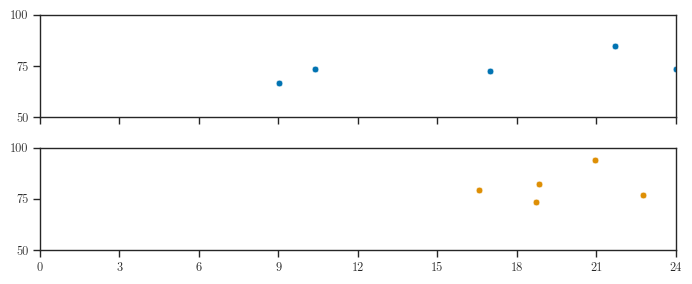

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=((7.08, 3)), sharex=True, sharey=True)
sns.scatterplot(x=empirical_cues, y=100*np.array(empirical_accuracy), ax=axes[0], color=palette[0])
sns.scatterplot(x=simulated_cues, y=100*np.array(simulated_accuracy), ax=axes[1], color=palette[1])
axes[0].set(ylim=((50, 100)), yticks=((50, 75, 100)))
axes[1].set(ylim=((50, 100)), yticks=((50, 75, 100)), xlim=((0, 24)), xticks=np.arange(0, 27, 3))
plt.tight_layout()